In [92]:
#from mat_image import MatImage
import numpy as np
import scipy.io
import sys
import scipy.ndimage as snd
#from image import Image
from scipy.stats import moment

from scipy.optimize import curve_fit


import matplotlib.pyplot as plt

In [3]:
sys.path.append('../../lcls-tools/lcls_tools/image_processing/')
    
from image_processing import image_processing as im
#x_projection, y_projection, gauss_fit, gauss_func

ImportError: cannot import name 'image_processing' from 'image_processing' (../../lcls-tools/lcls_tools/image_processing/image_processing.py)

In [263]:
otr_im = np.load("../../OTR_images_data/newdat/1618446887_img.npy")
n_col =  np.load("../../OTR_images_data/newdat/1618446887_ncol.npy")
n_row =  np.load("../../OTR_images_data/newdat/1618446887_nrow.npy")

# otr_im = np.load("../../OTR_images_data/newdat/1618450984_img.npy")
# n_col =  np.load("../../OTR_images_data/newdat/1618450984_ncol.npy")
# n_row =  np.load("../../OTR_images_data/newdat/1618450984_nrow.npy")

In [267]:
# this should be done in image acquisition, and otr_im passed onto im_processing
otr_im = otr_im.reshape(n_col,n_row)

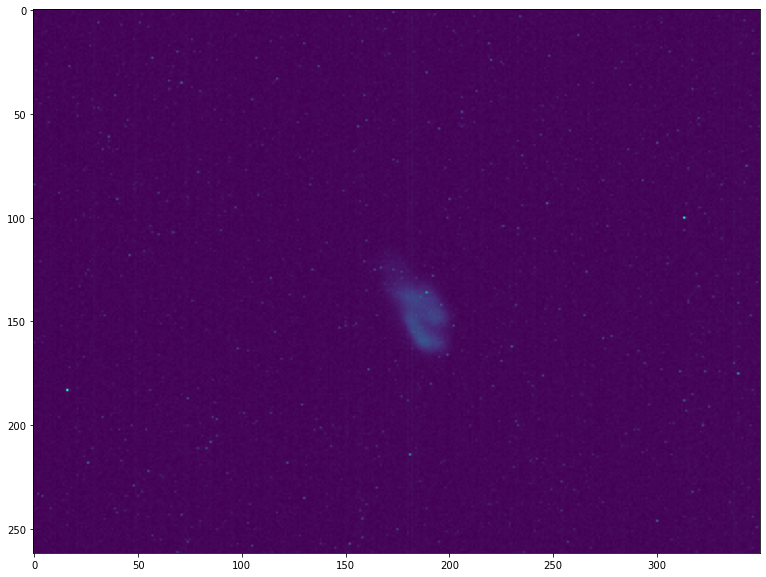

In [265]:
plt.figure(figsize=(15,10))
plt.imshow(otr_im)

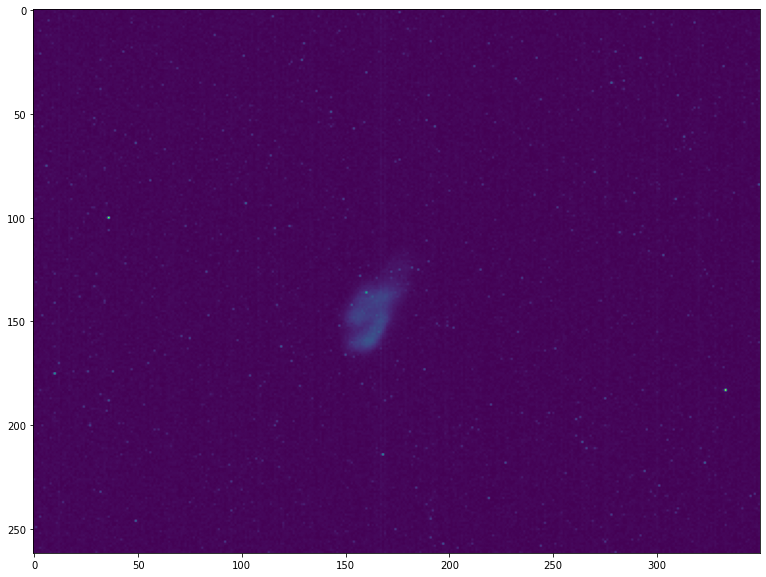

In [266]:
plt.figure(figsize=(15,10))
plt.imshow(np.fliplr(otr_im))

In [90]:
# from Nicole's files
# JUST TAKES A "PROFILE" aling center and fits Gaussian and takes STD???
# doesn't even work, I think initial guesses fail at fitting (see notebook)

def calculateRMS(image='None'):#Not complete
    '''Calculates x and y rms given a shaped image and um/pixel number; in this application only used for OTR2'''

    #Set a threshold while calculating center of mass
    ycentroid,xcentroid = snd.center_of_mass(image > (image.mean()+4*image.std()))

    #Take slice of xdata using ycentroid position
    xdataslice=image[int(ycentroid)]
    #Make simple xdata list with values from 0 to 639 (length 640)
    xdata=range(image.shape[1])

    #Fit gaussian using curve_fit, get coefficients back
    coeffx,var_matrixx = curve_fit(gaus,xdata,xdataslice,p0=[1,200,100])
    xfitmean,xstandarddeviation=coeffx[1],abs(coeffx[2])
    #xstandarddeviation = np.sqrt(np.diag(xstandarddeviation))
    
    
    ydataslice=[]
    for xline in image: 
        ydataslice.append(xline[int(xcentroid)])
    ydata=range(image.shape[0])

    #Fit gaussian using curve_fit, get coefficients back
    coeffy,var_matrixy = curve_fit(gaus,ydata,ydataslice,p0=[1,200,100])
    yfitmean,ystandarddeviation=coeffy[1],abs(coeffy[2])
    #ystandarddeviation = np.sqrt(np.diag(ystandarddeviation))
    
    xrms,yrms= xstandarddeviation,ystandarddeviation
    return coeffx, coeffy #, xrms,yrms

def gaus(x,a,x0,sigma):  
    return a*np.exp(-(x-x0)**2/(2*sigma**2))#Function just to return gaussian form for curve_fit

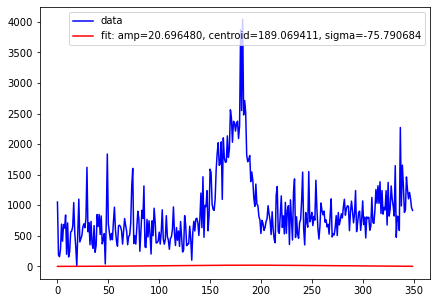

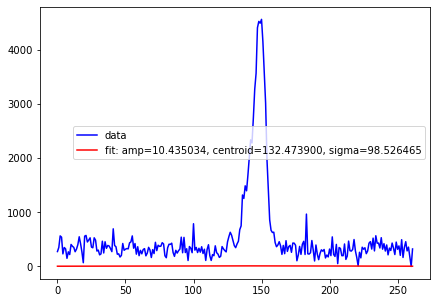

In [268]:
para_x = [ 20.69647966 ,189.06941056, -75.79068439,0,0]
para_y = [ 10.43503434 ,132.47390003, 98.52646538,0,0]

# plot it
fig = plt.figure(figsize=(7 ,5))
plt.plot(xx, x_proj, 'b-', label='data')
plt.plot(xx, gaussian_linear_background(xx, *para_x), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_x[:3]))
plt.legend()
plt.show()

fig = plt.figure(figsize=(7,5))
plt.plot(yy, y_proj, 'b-', label='data')
plt.plot(yy, gaussian_linear_background(yy, *para_y), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_y[:3]))
plt.legend()
plt.show()

# ============================

In [269]:
x_proj = im_projection(otr_im, axis=0) 
y_proj = im_projection(otr_im, axis=1)

x_proj = np.array([0 if ele < 0 else ele for ele in x_proj])
y_proj = np.array([0 if ele < 0 else ele for ele in y_proj])

xx = np.arange(x_proj.shape[0])
yy = np.arange(y_proj.shape[0])

In [176]:
def nmoment(x, counts, c, n):
    return np.sum(counts*(x-c)**n) / np.sum(counts)

In [177]:
nmoment(xx, x_proj, np.average(xx, weights=x_proj), 2)

8580.870918518078

In [178]:
xx1 = yy[y_proj != 0] 
xp1 = y_proj[y_proj != 0]

mean = np.sum(xx1*xp1)/ np.sum(xp1)
mean2 = np.sum(xx1*xx1*xp1)/np.sum(xp1)
var = mean2 - mean**2
std = np.sqrt(var)
mean, std

(134.84093314581492, 61.1259035419985)

In [171]:
cut_area/2*cumsum[-1]

2724.375

193.95077112167314 89.46106776901814


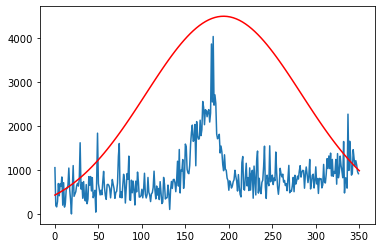

In [242]:
# 5% area cut
#y_proj = y_proj[110:190]

x_proj = im_projection(otr_im, axis=0) 
y_proj = im_projection(otr_im, axis=1)

xx = np.arange(x_proj.shape[0])
yy = np.arange(y_proj.shape[0])

def rms_cut_area(proj, cut_area=0.05):

    x = np.arange(proj.shape[0])
    proj = np.array([0 if ele < 0 else ele for ele in proj])

    cumsum = np.cumsum(proj)
    idLow = int(np.argwhere(cumsum < cut_area/2*cumsum[-1])[-1])
    idHigh = int(np.argwhere(cumsum > (1-cut_area/2)*cumsum[-1])[0])

    proj[0:idLow] = y_proj[idHigh:]=0

    xx = x[proj != 0] 
    xp = proj[proj != 0]

    mean = np.sum(xx*xp)/ np.sum(xp)
    mean2 = np.sum(xx*xx*xp)/np.sum(xp)
    var = mean2 - mean**2
    std = np.sqrt(var)
    
    return mean, std

mean, std = rms_cut_area(x_proj)
print(mean, std)
plt.plot(x_proj)
xt = np.linspace(0, len(x_proj),100)
plt.plot(xt, gaussian_linear_background(xt, 4500, mean, std, 0, 0), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_y[:3]))




In [243]:
y_proj =  y_proj[130:170]
y = y_proj
y

array([ 384,  347,  415,  466,  680,  749, 1320, 1256, 1489, 1397, 1688,
       2021, 2338, 2281, 2746, 3272, 3568, 4409, 4526, 4493, 4564, 4153,
       3592, 3018, 1977, 1425,  858,  668,  627,  633,  441,  364,  396,
        457,  380,  223,  388,  236,  476,  278])

17.20484210188322 6.16039331807257
1477.1172930745886


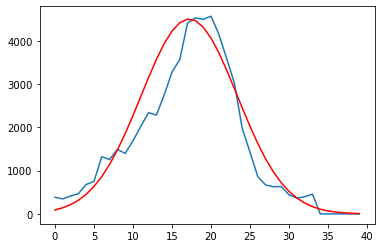

In [252]:

yt = np.arange(y.shape[0])
mean, std = rms_cut_area(y)
print(mean, std)
print(np.std(y))
plt.plot(y)


plt.plot(yt, gaussian_linear_background(yt, 4500, mean, std, 0, 0), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_y[:3]))


# ============================

In [79]:
plt.plot(im.x_projection(otr_im))

NameError: name 'im' is not defined

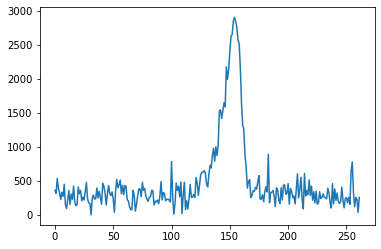

In [270]:
plt.plot(im.y_projection(otr_im))

In [270]:
def im_projection(image, axis=0, subtract_baseline=True):
    """Expects ndarray, return x (axis=0) or y (axis=1) projection"""
    proj = np.sum(image, axis)
    if subtract_baseline:
        return proj - min(proj)
    return proj

def gaussian_linear_background(x, amp, mu, sigma, slope, offset):
    return amp*np.exp( -(x-mu)**2/2/sigma**2 ) + slope * x + offset 

def fit_gaussian_linear_background_v2(x, y, para0 = None):
    if para0 == None:
        offset0 =  np.mean(y[-10:]) #y.min()
        amp0 = y.max() - offset0
        mu0 = x[np.argwhere(y==y.max())][0].item() # get the first element if more than two 
        try:
            sigma0 = (x[np.argwhere(y>np.exp(-0.5*2**2)*amp0+offset0).max()] - x[np.argwhere(y>np.exp(-0.5*2**2)*amp0+offset0).min()] )/(2*2)
        except:
            sigma0 = 5
        slope0 = 0
        para0 = [amp0, mu0, sigma0, slope0, offset0]
        
    try:
        para, para_error = curve_fit(gaussian_linear_background, x, y, p0 = para0)
    except:
        print("Fitting failed.")
        para = para0 
        para_error = []
    
    para[2] = abs(para[2])  # Gaussian width is postivie definite
    # contraints on the output fit parameters
    if para[2] >= len(x):
        para[2] = len(x)
        
    if abs(para[1]) <= 0:
        para[1] = 0
        
    if abs(para[1]) >= len(x):
        para[1] = len(x)
    return para, np.sqrt(np.diag(para_error)) #STD

In [271]:
def image_analysis(image, bg_image=None):
    if bg_image is not None and image.shape==bg_image.shape:
        image = image - bg_image

    x_proj = im_projection(image, axis=0)
    y_proj = im_projection(image, axis=1)

    xx = np.arange(x_proj.shape[0])
    yy = np.arange(y_proj.shape[0])

    # Gaussian fit
    para_x, para_error_x = fit_gaussian_linear_background_v2(xx, x_proj, para0 = None)
    para_y, para_error_y = fit_gaussian_linear_background_v2(yy, y_proj, para0 = None)
    
    # TODO: Add optional plotting and save plots of fitting
    #      size in x, size in y, error on x size, error on  y size
    return para_x[2],  para_y[2], para_error_x[2], para_error_y[2]

In [272]:
image_analysis(otr_im)

(7.451369560049449, 11.5641554833596, 0.28365201501859577, 0.3078932860607386)

In [273]:
x_proj = im_projection(otr_im, axis=0)
y_proj = im_projection(otr_im, axis=1)

xx = np.arange(x_proj.shape[0])
yy = np.arange(y_proj.shape[0])


# Gaussian fit
para_x, para_error_x = fit_gaussian_linear_background_v2(xx, x_proj)
para_y, para_error_y = fit_gaussian_linear_background_v2(yy, y_proj)

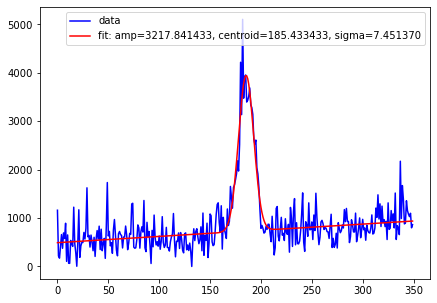

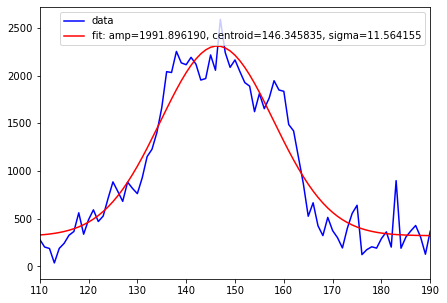

In [274]:
fig = plt.figure(figsize=(7 ,5))
plt.plot(xx, x_proj, 'b-', label='data')
plt.plot(xx, gaussian_linear_background(xx, *para_x), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_x[:3]))
plt.legend()
plt.show()

fig = plt.figure(figsize=(7,5))
plt.plot(yy, y_proj, 'b-', label='data')
plt.plot(yy, gaussian_linear_background(yy, *para_y), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_y[:3]))
plt.xlim(110,190)
plt.legend()
plt.show()

In [259]:
para_x[0:3], para_error_x
np.arange(len(y_proj))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [251]:
np.sqrt(0.8169)

0.9038252043398657

In [250]:
print(para_x)
print(para_error_x) # The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).
print(np.sqrt(np.diag(para_error_x))) # errors on parameter estimates

[1.84655414e+03 1.75501214e+02 1.22694820e+01 1.32834556e+00
 4.99475617e+02]
[84.91439656  0.64450944  0.66744271  0.16922377 35.03830411]
[[9.21490079 0.         0.         0.         0.        ]
 [0.         0.80281345 0.         0.         0.        ]
 [0.         0.         0.81697167 0.         0.        ]
 [0.         0.         0.         0.41136817 0.        ]
 [0.         0.         0.         0.         5.91931619]]


In [62]:
print(para_y)
print(para_error_y) # The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).
print(np.sqrt(np.diag(para_error_y))) # errors on parameter estimates

[2.41614387e+03 1.52199833e+02 7.48645641e+00 2.79950775e-02
 3.03580291e+02]
[57.25286539  0.20283713  0.20917492  0.1387653  20.89000081]
[[7.56656232 0.         0.         0.         0.        ]
 [0.         0.45037443 0.         0.         0.        ]
 [0.         0.         0.45735644 0.         0.        ]
 [0.         0.         0.         0.37251215 0.        ]
 [0.         0.         0.         0.         4.57055804]]


# ==================================

In [2]:
im1 = "../../../image_processing/emittance_scans_mat_files/Emittance-scan-OTRS_IN20_571-2021-06-08-201153.mat"

In [137]:
imat1 = scipy.io.loadmat(im1)
imat1['data'][0].dtype.names

('status',
 'type',
 'name',
 'quadName',
 'quadVal',
 'use',
 'ts',
 'beam',
 'beamStd',
 'beamList',
 'chargeList',
 'charge',
 'chargeStd',
 'rMatrix',
 'twiss0',
 'energy',
 'twiss',
 'twissstd',
 'orbit',
 'orbitstd',
 'twissPV')

70


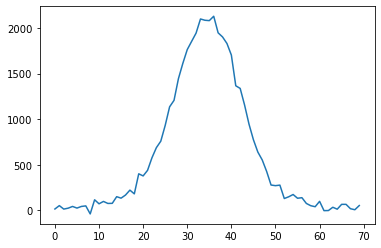

In [138]:
plt.plot(imat1['data'][0]['beam'][0][0,0]["profx"][1])
print((len(imat1['data'][0]['beam'][0][0,0]["profx"][1])))

36


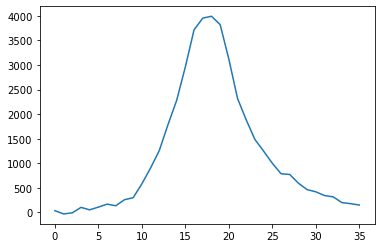

In [224]:
plt.plot(imat1['data'][0]['beam'][0][0,0]["profy"][1])
print((len(imat1['data'][0]['beam'][0][0,0]["profy"][1])))

# ==================================